In [1]:
%cd /content/drive/MyDrive/object_detection_yolov5/

/content/drive/MyDrive/object_detection_yolov5


In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import urllib
import requests
from PIL import Image
import cv2
import torch
import torchvision
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
RANDOM_SEED = 101
np.random.seed(RANDOM_SEED)

plt.rcParams['figure.figsize'] = (20,10)

In [4]:
j = json.loads(open('Indian_Number_plates.json').readline())

In [5]:
j

{'annotation': [{'imageHeight': 466,
   'imageWidth': 806,
   'label': ['number_plate'],
   'notes': '',
   'points': [{'x': 0.7220843672456576, 'y': 0.5879828326180258},
    {'x': 0.8684863523573201, 'y': 0.6888412017167382}]}],
 'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/77d1f81a-bee6-487c-aff2-0efa31a9925c____bd7f7862-d727-11e7-ad30-e18a56154311.jpg.jpeg',
 'extras': None}

In [6]:
license_plate = []
with open('Indian_Number_plates.json') as f:
  for line in f:
    license_plate.append(json.loads(line))

In [7]:
license_plate

[{'annotation': [{'imageHeight': 466,
    'imageWidth': 806,
    'label': ['number_plate'],
    'notes': '',
    'points': [{'x': 0.7220843672456576, 'y': 0.5879828326180258},
     {'x': 0.8684863523573201, 'y': 0.6888412017167382}]}],
  'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/77d1f81a-bee6-487c-aff2-0efa31a9925c____bd7f7862-d727-11e7-ad30-e18a56154311.jpg.jpeg',
  'extras': None},
 {'annotation': [{'imageHeight': 449,
    'imageWidth': 494,
    'label': ['number_plate'],
    'notes': '',
    'points': [{'x': 0.16194331983805668, 'y': 0.8507795100222717},
     {'x': 0.582995951417004, 'y': 1}]}],
  'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb0646e9cf9016473f1a561002a/4eb236a3-6547-4103-b46f-3756d21128a9___06-Sanjay-Dutt.jpg.jpeg',
  'extras': None},
 {'annotation': [{'imageHeight': 314,
    'imageWidth': 500,
    'label': ['number_plate'],
    'notes': '',
    'points': [{'x': 0.082, 'y': 0.69745222929936

In [8]:
df = pd.read_json('Indian_Number_plates.json', lines=True)

In [9]:
df.head()

,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN


In [10]:
df.annotation[0][0]['label']

['number_plate']

In [11]:
categories = []
for a in df.annotation:
  for l in a:
    categories.extend(l['label'])

categories = list(set(categories))
categories.sort()
categories


['number_plate']

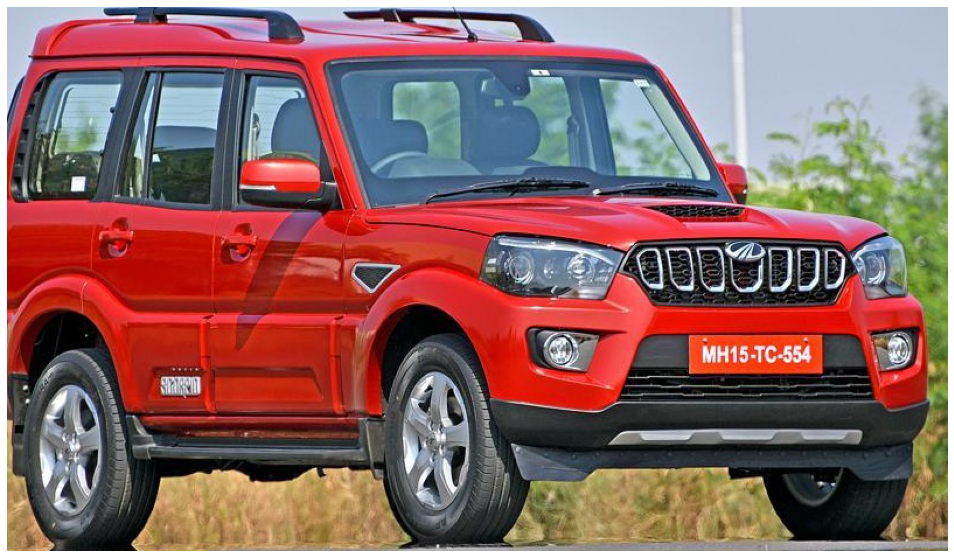

In [12]:
sample = df.iloc[0]

img = urllib.request.urlopen(sample['content'])
img = Image.open(img)
img.save('sample_image.jpeg', 'JPEG')

plt.axis('off')
plt.imshow(img)
plt.show()

In [13]:
img = cv2.cvtColor(cv2.imread(f'sample_image.jpeg'), cv2.COLOR_BGR2RGB)
img.shape

(466, 806, 3)

In [14]:
sample.annotation[0]['label']

['number_plate']

In [15]:
for a in sample.annotation:
  for label in a['label']:

    w = a['imageWidth']
    h = a['imageHeight']
    

    points = a['points']
    p1, p2 = points

    x1, y1 = p1['x']*w, p1['y']*h
    x2, y2 = p2['x']*w, p2['y']*h

    cv2.rectangle(img, 
                  (int(x1), int(y1)), 
                  (int(x2), int(y2)),
                  color = (0,255,0),
                  thickness = 2)
    
    ((label_width, label_height), _) = cv2.getTextSize(
        label, 
        fontFace=cv2.FONT_HERSHEY_PLAIN,
        fontScale=1.75, 
        thickness=2
    )

    cv2.rectangle(
      img,
      (int(x1), int(y1)),
      (int(x1 + label_width + label_width * 0.05), int(y1 + label_height + label_height * 0.25)),
      color=(0, 255, 0),
      thickness=cv2.FILLED
    )

    cv2.putText(
      img,
      label,
      org=(int(x1), int(y1 + label_height + label_height * 0.25)), 
      fontFace=cv2.FONT_HERSHEY_PLAIN,
      fontScale=1.75,
      color=(255, 255, 255),
      thickness=2
    )

(-0.5, 805.5, 465.5, -0.5)

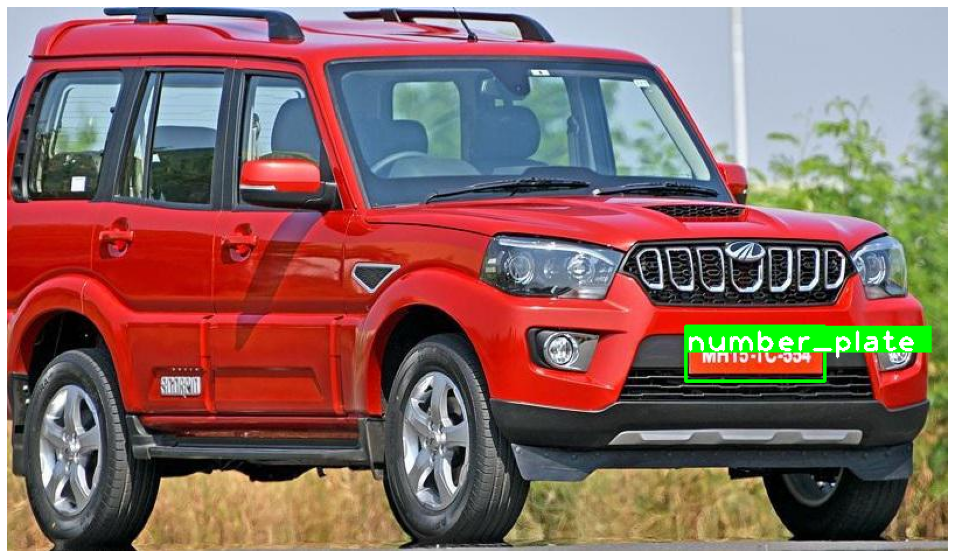

In [16]:
plt.imshow(img)
plt.axis('off')

In [17]:
train_df, test_df = train_test_split(license_plate, test_size=0.1)
len(train_df), len(test_df)

(213, 24)

In [18]:
def create_dataset(license_plate, categories, dataset_type):

  images_path = Path(f"license_plate/images/{dataset_type}")
  images_path.mkdir(parents=True, exist_ok=True)

  labels_path = Path(f"license_plate/labels/{dataset_type}")
  labels_path.mkdir(parents=True, exist_ok=True)

  for img_id, row in enumerate(license_plate):

    image_name = f"{img_id}.jpeg"

    img = urllib.request.urlopen(row["content"])
    img = Image.open(img)
    img = img.convert("RGB")

    img.save(str(images_path / image_name), "JPEG")

    label_name = f"{img_id}.txt"

    with (labels_path / label_name).open(mode="w") as label_file:

      for a in row['annotation']:

        for label in a['label']:

          category_idx = categories.index(label)

          points = a['points']
          p1, p2 = points

          x1, y1 = p1['x'], p1['y']
          x2, y2 = p2['x'], p2['y']

          bbox_width = x2 - x1
          bbox_height = y2 - y1

          label_file.write(
            f"{category_idx} {x1 + bbox_width / 2} {y1 + bbox_height / 2} {bbox_width} {bbox_height}\n"
          )

In [19]:
create_dataset(train_df, categories, 'train')
create_dataset(test_df, categories, 'val')

In [20]:
!sudo apt-get install tree -qq > /dev/null

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [21]:
!tree license_plate -L 2

license_plate
├── images
│   ├── train
│   └── val
└── labels
    ├── train
    └── val

6 directories, 0 files


In [22]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 3773 (delta 68), reused 69 (delta 33), pack-reused 3662
Receiving objects: 100% (3773/3773), 7.14 MiB | 12.99 MiB/s, done.
Resolving deltas: 100% (2518/2518), done.
/content/drive/My Drive/object_detection_yolov5/yolov5
     |████████████████████████████████| 276kB 7.6MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=4251f2b1959edc4f82525b93ab37d2b547a3c4354feb8b0e15a64de267771724
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built PyYAML
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [23]:
!python train.py --img 640 --batch 8 --epochs 30 \
  --data ./data/license_plate.yaml --cfg ./models/yolov5x_license_plate.yaml --weights yolov5x.pt \
  --name yolov5x_license_plate --cache

Using torch 1.7.0+cu101 CUDA:0 (Tesla T4, 15079.75MB)

Namespace(adam=False, batch_size=8, bucket='', cache_images=True, cfg='./models/yolov5x_license_plate.yaml', data='./data/license_plate.yaml', device='', epochs=30, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[640, 640], local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='yolov5x_license_plate', noautoanchor=False, nosave=False, notest=False, project='runs/train', rect=False, resume=False, save_dir='runs/train/yolov5x_license_plate', single_cls=False, sync_bn=False, total_batch_size=8, weights='yolov5x.pt', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
2020-12-31 13:38:58.450730: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Hyperparameters {'lr0': 0.01, 'lrf': 0.2, 'momentum': 0.937, 'weight_decay': 0.0005, 'war

In [40]:
!python detect.py --weights runs/train/yolov5x_license_plate/weights/best.pt \
  --img 640 --conf 0.4 --source ../license_plate/images/val/

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='../license_plate/images/val/', update=False, view_img=False, weights=['runs/train/yolov5x_license_plate/weights/best.pt'])
Using torch 1.7.0+cu101 CUDA:0 (Tesla T4, 15079.75MB)

Fusing layers... 
Model Summary: 484 layers, 88390614 parameters, 0 gradients, 219.8 GFLOPS
image 1/24 /content/drive/My Drive/object_detection_yolov5/license_plate/images/val/0.jpeg: 480x640 1 number_plates, Done. (0.042s)
image 2/24 /content/drive/My Drive/object_detection_yolov5/license_plate/images/val/1.jpeg: 416x640 1 number_plates, Done. (0.037s)
image 3/24 /content/drive/My Drive/object_detection_yolov5/license_plate/images/val/10.jpeg: 480x640 1 number_plates, Done. (0.039s)
image 4/24 /content/drive/My Drive/object_detection_yolov5/license_plate/images/val/11.jpeg: 384x640 1 number_plates, Done. (

In [41]:

def load_image(img_path: Path, resize=True):
  img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (128, 256), interpolation = cv2.INTER_AREA)
  return img

def show_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

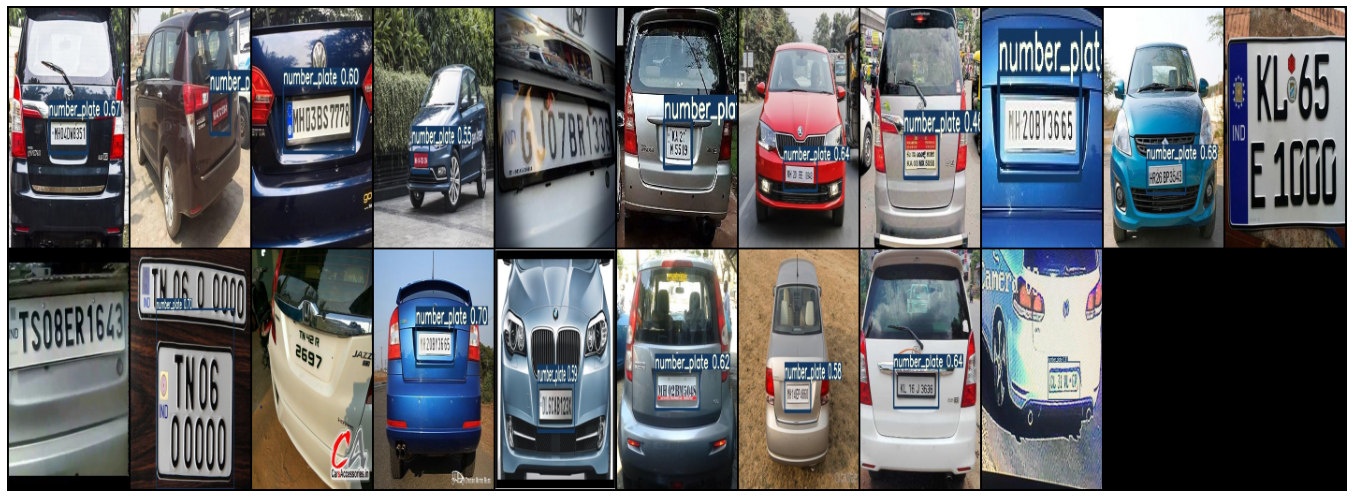

In [42]:
img_paths = list(Path('runs/detect/exp2').glob('*.jpeg'))[:20]
show_grid(img_paths)